# 方案B: 贝叶斯MCMC模型（修正版）

---

## 模型评估指标汇总

本模型提供以下**六大核心指标**来评估粉丝投票估算的质量：

### 一、预测准确性指标（模型能否准确预测淘汰结果？）

| 指标名称 | 英文名 | 定义 | 计算公式 | 解释 |
|----------|--------|------|----------|------|
| **淘汰一致率** | Elimination Consistency Rate | 模型预测的淘汰者与实际淘汰者一致的周数比例 | $\frac{\text{预测正确的周数}}{\text{总周数}} \times 100\%$ | 100%表示模型完美解释了所有淘汰结果 |
| **接受率** | Acceptance Rate | MCMC采样中被接受的候选样本比例 | $\frac{\text{被接受的样本数}}{\text{总样本数}}$ | 反映淘汰结果的"合理性"：高=符合预期，低=意外/冷门 |

### 二、估计确定性指标（粉丝投票估计有多可靠？）

| 指标名称 | 英文名 | 定义 | 计算公式 | 解释 |
|----------|--------|------|----------|------|
| **估算均值** | Mean Estimation | 后验分布的期望值 | $\bar{F}_i = \frac{1}{N}\sum_{t=1}^{N} F_i^{(t)}$ | 该选手最可能的粉丝投票百分比 |
| **95%置信区间** | 95% Confidence Interval | 后验分布的2.5%和97.5%分位数 | $[Q_{2.5\%}, Q_{97.5\%}]$ | 我们有95%信心认为真实值在此区间内 |
| **置信区间宽度** | CI Width | 置信区间上界减下界 | $CI_{width} = Q_{97.5\%} - Q_{2.5\%}$ | 宽度越小，估计越精确 |
| **确定性度量** | Certainty Measure | 基于CI宽度的归一化指标 | $Certainty = 1 - \frac{\bar{CI}_{width}}{100\%}$ | 0%=完全不确定，100%=完全确定 |

### 三、指标的层次结构

```
┌─────────────────────────────────────────────────────────────────┐
│                    模型评估指标体系                              │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  【第一层：整体模型质量】                                        │
│  ├── 淘汰一致率 (Consistency Rate)                              │
│  │   └── 问题：模型能否解释所有淘汰结果？                        │
│  │   └── 理想值：100%                                           │
│  │                                                              │
│  【第二层：单周分析质量】                                        │
│  ├── 接受率 (Acceptance Rate)                                   │
│  │   └── 问题：该周淘汰结果有多"合理"？                          │
│  │   └── 高(>70%)=正常，中(40-70%)=有意外，低(<40%)=冷门         │
│  │                                                              │
│  【第三层：选手级别估计】                                        │
│  ├── 估算均值 (Mean)                                            │
│  │   └── 问题：该选手粉丝投票大约是多少？                        │
│  ├── 置信区间 (CI)                                              │
│  │   └── 问题：这个估计有多大把握？                              │
│  └── 确定性度量 (Certainty)                                     │
│      └── 问题：估计的精确程度如何？                              │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

### 四、确定性是否对每位选手/每周保持一致？

**答案：不一致。** 确定性会因以下因素而变化：

| 影响因素 | 对确定性的影响 | 原因 |
|----------|----------------|------|
| **选手数量** | 选手越多，确定性越低 | 更多维度意味着更大的不确定性空间 |
| **评委分数差距** | 差距越大，确定性越高 | 大差距限制了可行的粉丝投票范围 |
| **淘汰者评委排名** | 排名越低，确定性越高 | 评委分数最低者被淘汰是"正常"的，约束宽松 |
| **是否为冷门** | 冷门周确定性更高 | 可行域小，粉丝投票被严格限制 |

### 五、指标使用指南

| 我想知道... | 应该看哪个指标 |
|-------------|----------------|
| 模型整体是否可靠？ | 淘汰一致率（应为100%） |
| 某周淘汰是否意外？ | 接受率（<40%为冷门） |
| 某选手粉丝有多少？ | 估算均值 |
| 这个估计可信吗？ | 置信区间宽度 / 确定性度量 |
| 哪些选手估计更准？ | 比较各选手的CI宽度 |

---

## 一、问题背景与挑战

### 1.1 问题描述
在《与星共舞》(Dancing with the Stars)节目中，每周的淘汰结果由**评委打分**和**粉丝投票**共同决定。
- **已知信息**：评委打分（公开）、淘汰结果（公开）
- **未知信息**：粉丝投票的具体分布（从未公开）

我们的目标是：**根据已知的评委打分和淘汰结果，反推出粉丝投票的可能分布**。

### 1.2 问题的数学本质
这是一个典型的**逆问题(Inverse Problem)**：
- 正向过程：评委分数 + 粉丝投票 → 综合得分 → 淘汰结果
- 逆向推断：评委分数 + 淘汰结果 → 粉丝投票（？）

### 1.3 核心挑战
1. **欠定问题**：一个淘汰结果可能对应无穷多种粉丝投票分布
2. **约束复杂**：粉丝投票必须满足淘汰约束（淘汰者得分最低）
3. **规则变化**：不同赛季采用不同的计分规则（百分比法 vs 排名法）
4. **不确定性量化**：需要给出估计的可信程度，而非单一点估计


## 1. 环境配置

In [36]:
# ==================== 导入必要的Python库 ====================
# pandas: 用于数据处理和分析，提供DataFrame数据结构
import pandas as pd

# numpy: 用于数值计算，提供高效的数组操作和数学函数
import numpy as np

# scipy.stats: 用于统计计算，本项目中主要用于排名计算(rankdata)
from scipy import stats

# matplotlib.pyplot: 用于数据可视化，绑制各种统计图表
import matplotlib.pyplot as plt

# warnings: 用于控制警告信息的显示
import warnings
# 忽略所有警告信息，避免输出中出现不必要的警告干扰
warnings.filterwarnings('ignore')

# ==================== 设置随机种子 ====================
# 设置numpy的随机种子为42，确保实验结果可复现
# 这对于MCMC采样非常重要，因为采样过程涉及大量随机数生成
np.random.seed(42)

# ==================== 配置matplotlib绑图参数 ====================
# 设置中文字体，优先使用SimHei(黑体)，备选DejaVu Sans
# 这样可以在图表中正确显示中文标签和标题
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']

# 解决负号显示问题，确保坐标轴上的负号能正确显示
plt.rcParams['axes.unicode_minus'] = False

# 使用seaborn的白色网格样式，使图表更加美观专业
plt.style.use('seaborn-v0_8-whitegrid')

# ==================== 定义配色方案 ====================
# 定义一组专业的配色方案，用于图表中不同类别的区分
# 这些颜色来自Nature期刊的配色方案，视觉效果好且易于区分
# COLORS[0]: 红色 - 用于排名法(S1-2)或淘汰者
# COLORS[1]: 青色 - 用于百分比法(S3-27)或幸存者
# COLORS[2]: 绿色 - 用于排名法(S28-34)
# COLORS[3]: 蓝色 - 备用颜色
# COLORS[4]: 橙色 - 备用颜色
COLORS = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F']

print('环境配置完成')

环境配置完成


## 2. 加载数据

In [37]:
# ==================== 加载数据文件 ====================
# 从Excel文件中读取已经预处理好的粉丝投票分析数据
# 数据路径使用相对路径，指向上两级目录的data/processed文件夹
# 该数据集包含了《与星共舞》(Dancing with the Stars)节目的历史数据
df = pd.read_excel('../../data/processed/粉丝投票分析.xlsx')

# ==================== 输出数据基本信息 ====================
# 打印数据维度：(行数, 列数)
# 行数表示总记录数，列数表示特征/变量数量
print(f'数据维度: {df.shape}')

# 打印赛季范围，了解数据覆盖的时间跨度
# 使用min()和max()获取赛季的最小值和最大值
print(f'赛季范围: S{df["赛季"].min()} - S{df["赛季"].max()}')

数据维度: (2777, 15)
赛季范围: S1 - S34


## 3. 数据预处理

In [38]:
def get_scoring_method(season):
    """
    根据赛季确定计分规则
    
    《与星共舞》节目在不同赛季采用了不同的计分规则：
    - S1-2 (第1-2季): 排名相加法
      评委排名 + 粉丝排名 = 综合排名，排名数字越小越好
    - S3-27 (第3-27季): 百分比相加法
      评委得分百分比 + 粉丝投票百分比 = 综合得分，得分越高越好
    - S28-34 (第28-34季): 排名相加法（含底部投票机制）
      回归排名相加法，但增加了底部投票等新规则
    
    参数:
        season (int): 赛季编号
    
    返回:
        str: 计分规则类型，'ranking'表示排名法，'percentage'表示百分比法
    """
    if season <= 2:
        return 'ranking'  # S1-2: 排名相加
    elif season <= 27:
        return 'percentage'  # S3-27: 百分比相加
    else:
        return 'ranking'  # S28-34: 排名相加（含底部投票）

def prepare_week_data(df, season, week):
    """
    准备单周数据，提取MCMC采样所需的所有信息
    
    该函数从原始数据中提取指定赛季和周次的数据，
    并整理成适合贝叶斯MCMC模型使用的格式。
    
    参数:
        df (DataFrame): 包含所有赛季数据的DataFrame
        season (int): 目标赛季编号
        week (int): 目标周次编号
    
    返回:
        dict or None: 包含以下键值的字典，如果数据无效则返回None
            - 'season': 赛季编号
            - 'week': 周次编号
            - 'contestants': 选手姓名列表
            - 'judge_scores': 评委总分数组(numpy array)
            - 'judge_pct': 评委得分百分比数组(numpy array)
            - 'eliminated': 被淘汰选手姓名列表
            - 'scoring_method': 计分规则('ranking'或'percentage')
            - 'n': 参赛选手数量
    """
    # 筛选指定赛季和周次的数据
    week_df = df[(df['赛季'] == season) & (df['第几周'] == week)].copy()
    
    # 过滤掉评委总分为0的记录（可能是缺失数据或特殊情况）
    week_df = week_df[week_df['本周评委总分'] > 0]
    
    # 如果没有有效数据，返回None
    if len(week_df) == 0:
        return None
    
    # 获取被淘汰选手列表（是否被淘汰字段为1的选手）
    eliminated = week_df[week_df['是否被淘汰'] == 1]['选手姓名'].tolist()
    
    # 如果没有淘汰者，说明这周没有淘汰赛，返回None
    # （例如决赛周或特殊周次）
    if len(eliminated) == 0:
        return None
    
    # 返回整理好的数据字典
    return {
        'season': season,                                          # 赛季编号
        'week': week,                                              # 周次编号
        'contestants': week_df['选手姓名'].tolist(),               # 选手姓名列表
        'judge_scores': week_df['本周评委总分'].values.astype(float),  # 评委总分
        'judge_pct': week_df['评委百分比'].values.astype(float),   # 评委得分百分比
        'eliminated': eliminated,                                  # 被淘汰选手
        'scoring_method': get_scoring_method(season),              # 计分规则
        'n': len(week_df)                                          # 选手数量
    }

print('数据预处理函数定义完成')

数据预处理函数定义完成


## 4. 综合得分计算

In [39]:
def compute_total_score(fan_pct, week_data):
    """
    计算综合得分
    
    根据不同的计分规则计算选手的综合得分。
    这是贝叶斯模型的核心函数之一，用于评估给定粉丝投票分布下的淘汰结果。
    
    计分规则说明:
    - 百分比法(S3-27): 
      综合得分 = 评委得分百分比 + 粉丝投票百分比
      得分越高越好，最高分的选手最安全
    
    - 排名法(S1-2, S28-34): 
      综合排名 = 评委排名 + 粉丝排名
      排名越小越好（第1名比第2名好）
      为了统一处理，我们用负数表示，这样数值越大越好
    
    参数:
        fan_pct (numpy array): 粉丝投票百分比数组，每个元素对应一个选手
        week_data (dict): 包含周数据的字典，由prepare_week_data函数生成
    
    返回:
        numpy array: 综合得分数组，数值越大表示表现越好
    """
    # 获取计分规则和选手数量
    method = week_data['scoring_method']
    n = week_data['n']
    
    if method == 'percentage':
        # ========== 百分比相加法 ==========
        # 直接将评委百分比和粉丝百分比相加
        # 得分越高越好，最高分的选手最安全
        total = week_data['judge_pct'] + fan_pct
    else:
        # ========== 排名相加法 ==========
        # 首先计算评委排名：分数越高排名越小（第1名）
        # 使用负号是因为rankdata默认升序排名，我们需要降序
        # method='average'表示相同分数取平均排名
        judge_rank = stats.rankdata(-week_data['judge_scores'], method='average')
        
        # 计算粉丝排名：投票百分比越高排名越小
        fan_rank = stats.rankdata(-fan_pct, method='average')
        
        # 综合排名 = 评委排名 + 粉丝排名
        # 用负数表示，这样数值越大越好（与百分比法一致）
        # 例如：排名和为3的选手得分为-3，比排名和为5的选手(-5)更好
        total = -(judge_rank + fan_rank)
    
    return total

def check_elimination_constraint(fan_pct, week_data):
    """
    检查淘汰约束是否满足
    
    这是贝叶斯MCMC模型的核心约束函数。
    在真实比赛中，被淘汰的选手一定是综合得分最差的。
    因此，任何有效的粉丝投票分布都必须满足这个约束。
    
    约束条件:
    淘汰者的最高综合得分 < 幸存者的最低综合得分
    （允许淘汰者之间并列最差）
    
    参数:
        fan_pct (numpy array): 粉丝投票百分比数组
        week_data (dict): 周数据字典
    
    返回:
        bool: True表示约束满足（淘汰者确实是最差的），False表示约束不满足
    """
    contestants = week_data['contestants']
    eliminated = week_data['eliminated']
    
    # 计算所有选手的综合得分
    total_scores = compute_total_score(fan_pct, week_data)
    
    # 获取淘汰者的索引列表
    # 通过在contestants列表中查找eliminated中每个选手的位置
    elim_idx = [contestants.index(e) for e in eliminated if e in contestants]
    
    # 获取幸存者的索引列表（不在淘汰者列表中的选手）
    surv_idx = [i for i in range(len(contestants)) if i not in elim_idx]
    
    # 边界情况处理：如果没有淘汰者或没有幸存者，认为约束满足
    if len(elim_idx) == 0 or len(surv_idx) == 0:
        return True
    
    # 计算淘汰者中的最高得分
    # 如果有多个淘汰者，取他们中得分最高的
    max_elim_score = max(total_scores[i] for i in elim_idx)
    
    # 计算幸存者中的最低得分
    # 幸存者中得分最低的那个
    min_surv_score = min(total_scores[i] for i in surv_idx)
    
    # 约束检查：淘汰者的最高分必须严格小于幸存者的最低分
    # 这确保了淘汰者确实是综合表现最差的
    return max_elim_score < min_surv_score

print('综合得分计算和约束检查函数定义完成')

综合得分计算和约束检查函数定义完成


## 5. MCMC采样器（带硬约束）

In [40]:
# ==================================================================================
# 第5部分：MCMC采样器 - 蒙特卡洛马尔可夫链采样的核心实现
# ==================================================================================
#
# 【《与星共舞》问题背景回顾】
# 在节目中，我们已知：
#   - 评委打分 J = (J_1, J_2, ..., J_n)  （公开信息）
#   - 淘汰结果 E = {被淘汰选手}           （公开信息）
# 我们要估计：
#   - 粉丝投票 F = (F_1, F_2, ..., F_n)  （未知，需要推断）
#
# 【核心挑战】
# 粉丝投票F是一个n维向量，必须满足：
#   1. 非负约束：F_i >= 0（投票不能为负）
#   2. 归一化约束：sum(F_i) = 100%（所有选手投票之和为100%）
#   3. 淘汰约束：淘汰者的综合得分必须是最低的
# 满足这些约束的F构成一个复杂的高维区域（可行域），无法直接采样
#
# 【MCMC的核心思想】
# 马尔可夫链蒙特卡洛(Markov Chain Monte Carlo)方法：
#   1. 构造一个马尔可夫链，使其平稳分布就是我们想要的后验分布
#   2. 通过在链上"随机游走"，我们可以得到后验分布的样本
#   3. 即使不知道归一化常数，也能正确采样！
#
# 【本实现的算法流程】
#   Step 1: 初始化 - 用拒绝采样找到一个满足约束的起点
#   Step 2: 迭代 - 重复以下过程n_samples + burn_in次：
#           a) 从当前点生成一个候选点（建议分布）
#           b) 检查候选点是否满足淘汰约束
#           c) 如果满足，移动到候选点；否则，留在原地
#   Step 3: 收集 - 丢弃前burn_in个样本，保留后面的作为后验样本
# ==================================================================================

def symmetric_proposal(current, step_size=5.0):
    """
    【建议分布函数】- Metropolis-Hastings算法的核心组件
    
    ============================================================
    功能：从当前粉丝投票分布生成一个新的候选分布
    ============================================================
    
    【在《与星共舞》问题中的作用】
    假设当前我们猜测某周4位选手的粉丝投票分布是：
        F_current = [30%, 25%, 25%, 20%]  对应选手A, B, C, D
    
    建议分布会在这个基础上随机扰动，生成一个新的候选分布：
        F_proposed = [32%, 23%, 27%, 18%]
    
    然后我们会检查这个候选分布是否能解释实际的淘汰结果。
    如果能（即淘汰者在这个分布下确实得分最低），就接受它；
    否则，保持原来的分布不变。
    
    【为什么使用"对称"建议分布？】
    对称性意味着：从F到F'的转移概率 = 从F'到F的转移概率
    数学表达：q(F'|F) = q(F|F')
    
    这个性质极大简化了Metropolis-Hastings算法的接受率计算：
    原始MH接受率：alpha = min(1, [P(F')*q(F|F')] / [P(F)*q(F'|F)])
    对称时简化为：alpha = min(1, P(F') / P(F))
    由于我们使用均匀先验，进一步简化为：
      如果F'满足淘汰约束：alpha = 1（总是接受）
      如果F'不满足约束：alpha = 0（总是拒绝）
    
    【算法步骤详解】
    1. 正态扰动：在每个选手的投票百分比上加随机噪声
       噪声服从 N(0, step_size^2) 分布
       例如：noise = [+2.1, -1.5, +3.2, -0.8]
    
    2. 非负投影：粉丝投票不能为负数
       将任何负值截断为0.01（用0.01而非0避免数值问题）
    
    3. 归一化：所有选手的粉丝投票之和必须为100%
       将结果缩放使总和恰好为100%
    
    【参数说明】
    current (numpy array): 当前粉丝投票分布
        例如：[30.0, 25.0, 25.0, 20.0] 表示4位选手的投票百分比
    
    step_size (float): 扰动强度（正态分布的标准差），默认5.0
        太大（如20）：探索范围广，但很多候选点会违反约束，效率低
        太小（如0.5）：接受率高，但探索慢，需要更多迭代才能遍历可行域
        经验值5.0在大多数情况下效果较好
    
    【返回值】
    numpy array: 新的候选粉丝投票分布，满足非负和归一化约束
    """
    n = len(current)  # 选手数量
    
    # ===== 步骤1：生成正态分布的随机扰动 =====
    # 对每个选手的投票百分比独立添加随机噪声
    # 噪声服从均值为0、标准差为step_size的正态分布
    # 例如：current = [30, 25, 25, 20], noise可能是 [2.1, -1.5, 3.2, -0.8]
    noise = np.random.normal(0, step_size, n)
    
    # ===== 步骤2：将扰动添加到当前点 =====
    # proposed = current + noise = [32.1, 23.5, 28.2, 19.2]
    proposed = current + noise
    
    # ===== 步骤3：投影到非负空间 =====
    # 粉丝投票不能为负数，将负值截断为0.01
    # 使用0.01而不是0是为了避免后续计算中可能的除零问题
    proposed = np.maximum(proposed, 0.01)
    
    # ===== 步骤4：归一化到100% =====
    # 粉丝投票是一个概率分布，所有选手的投票之和必须为100%
    # 通过缩放实现：new_value = old_value / sum(all_values) * 100
    proposed = proposed / proposed.sum() * 100
    
    return proposed


def rejection_sample_prior(n, week_data, max_attempts=3000):
    """
    【拒绝采样初始化】- 为MCMC链找到一个有效的起点
    
    ============================================================
    功能：从先验分布中采样，直到找到一个满足淘汰约束的粉丝投票分布
    ============================================================
    
    【为什么需要这个函数？】
    MCMC算法需要一个起点来开始"随机游走"。
    但不是任意的粉丝投票分布都能解释实际的淘汰结果。
    例如，如果实际被淘汰的是选手D，但我们随机生成的分布让选手A得分最低，
    这个分布就不满足约束，不能作为起点。
    
    【先验分布的选择：狄利克雷(Dirichlet)分布】
    我们使用 Dirichlet(1,1,...,1) 作为先验分布。
    
    狄利克雷分布是定义在概率单纯形上的分布，其概率密度函数为：
    P(F|alpha) = [Gamma(sum(alpha_i)) / prod(Gamma(alpha_i))] * prod(F_i^(alpha_i-1))
    
    当所有参数 alpha_i = 1 时：
    - 概率密度变为常数，即单纯形上的均匀分布
    - 这是"无信息先验"，表示我们对粉丝投票没有任何先入为主的偏见
    - 所有满足 sum(F_i)=100% 且 F_i>=0 的分布都是等可能的
    
    为什么狄利克雷分布是自然的选择？
    1. 它自动满足粉丝投票的约束：非负性和归一化
    2. 它是多项分布的共轭先验，数学性质优良
    3. numpy提供了高效的采样函数 np.random.dirichlet()
    
    【拒绝采样的原理】
    这是一种简单但有效的采样方法：
    1. 从先验分布中随机生成一个样本
    2. 检查这个样本是否满足我们的约束条件
    3. 如果满足，接受它；如果不满足，丢弃它，重新生成
    4. 重复直到找到一个有效样本
    
    【在《与星共舞》问题中的应用】
    假设某周有4位选手，选手D被淘汰：
    随机生成：F = [20%, 30%, 25%, 25%]
    计算综合得分，检查选手D是否得分最低
    如果是，这个F可以作为MCMC的起点
    如果不是，丢弃这个F，重新生成
    
    【参数说明】
    n (int): 选手数量，即粉丝投票分布的维度
    week_data (dict): 包含该周所有信息的字典
        'contestants': 选手姓名列表
        'judge_scores': 评委打分
        'eliminated': 被淘汰选手
        等等
    max_attempts (int): 最大尝试次数，默认3000
        防止在约束极其严格时陷入无限循环
    
    【返回值】
    numpy array: 满足淘汰约束的粉丝投票分布
    None: 如果在max_attempts次尝试后仍找不到有效样本
    """
    for attempt in range(max_attempts):
        # ===== 从狄利克雷分布 Dirichlet(1,...,1) 采样 =====
        # 
        # 【狄利克雷分布采样原理】
        # np.random.dirichlet(alpha) 从参数为alpha的狄利克雷分布中采样
        # 当 alpha = [1, 1, ..., 1] 时，这等价于在概率单纯形上均匀采样
        # 
        # 【采样结果的性质】
        # 返回一个n维向量，满足：
        #   1. 每个分量 >= 0（非负性）
        #   2. 所有分量之和 = 1（归一化）
        # 
        # 【转换为百分比】
        # 乘以100将概率转换为百分比形式
        # 例如：[0.25, 0.30, 0.20, 0.25] -> [25%, 30%, 20%, 25%]
        # 这样更符合"粉丝投票百分比"的直观理解
        #
        sample = np.random.dirichlet(np.ones(n)) * 100
        
        # ===== 检查是否满足淘汰约束 =====
        # 调用check_elimination_constraint函数验证：
        # 在这个粉丝投票分布下，被淘汰的选手是否确实综合得分最低
        if check_elimination_constraint(sample, week_data):
            return sample  # 找到有效样本，返回
    
    # 如果达到最大尝试次数仍未找到有效样本，返回None
    # 这种情况很少发生，除非约束极其严格（可行域非常小）
    return None


def mcmc_sample_constrained(week_data, n_samples=2000, burn_in=500, step_size=5.0):
    """
    【带硬约束的MCMC采样】- 贝叶斯推断的核心实现
    
    ============================================================
    功能：使用Metropolis-Hastings算法从后验分布中采样
    这是整个贝叶斯MCMC模型的核心函数
    ============================================================
    
    【《与星共舞》问题的贝叶斯建模】
    
    我们要解决的问题：
    已知评委打分J和淘汰结果E，估计粉丝投票F的分布
    
    贝叶斯框架：
    后验 正比于 似然 乘以 先验
    P(F|E,J) 正比于 P(E|F,J) * P(F)
    
    各部分的设计：
    1. 先验 P(F): Dirichlet(1,...,1) = 均匀分布
       含义：在没有数据时，我们认为所有粉丝投票分布都是等可能的
    
    2. 似然 P(E|F,J): 硬约束指示函数
       P(E|F,J) = 1  如果在粉丝投票F下，淘汰者E确实综合得分最低
       P(E|F,J) = 0  否则
       含义：只有能解释实际淘汰结果的粉丝投票分布才有非零概率
    
    3. 后验 P(F|E,J): 可行域上的均匀分布
       由于先验是均匀的，似然是0-1指示函数，
       后验就是在"满足淘汰约束的粉丝投票分布"这个集合上的均匀分布
    
    【Metropolis-Hastings算法详解】
    
    MH算法是一种通用的MCMC方法，可以从任意分布中采样。
    
    标准MH算法步骤：
    1. 初始化：选择一个起点 F^(0)
    2. 对于 t = 1, 2, ..., T：
       a) 从建议分布 q(F'|F^(t-1)) 生成候选点 F'
       b) 计算接受概率：
          alpha = min(1, [P(F')*q(F^(t-1)|F')] / [P(F^(t-1))*q(F'|F^(t-1))])
       c) 以概率alpha接受F'，即 F^(t) = F'
          以概率1-alpha拒绝，即 F^(t) = F^(t-1)
    
    【本实现的简化】
    
    由于我们使用：
    对称建议分布：q(F'|F) = q(F|F')
    均匀先验：P(F) = 常数
    硬约束似然：P(E|F,J) 属于 {0, 1}
    
    接受概率简化为：
    alpha = 1  如果F'满足淘汰约束（总是接受）
    alpha = 0  如果F'不满足约束（总是拒绝）
    
    这大大简化了实现！
    
    【预热期(Burn-in)的作用】
    
    MCMC的前若干个样本可能受初始点影响，尚未达到平稳分布。
    预热期的样本会被丢弃，只保留之后的样本用于推断。
    
    类比：就像烧水，刚开始水温不稳定，要等水烧开（达到平稳）后才能用。
    
    【参数说明】
    week_data (dict): 周数据字典，包含：
        'n': 选手数量
        'contestants': 选手姓名列表
        'judge_scores': 评委打分
        'judge_pct': 评委得分百分比
        'eliminated': 被淘汰选手
        'scoring_method': 计分规则
    
    n_samples (int): 需要采集的后验样本数量，默认2000
        样本越多，后验估计越准确，但计算时间越长
    
    burn_in (int): 预热期长度，默认500
        这些样本会被丢弃，不用于最终推断
    
    step_size (float): 建议分布的步长，默认5.0
        控制每次"随机游走"的幅度
    
    【返回值】
    tuple: (samples, acceptance_rate)
        samples: numpy array, 形状为(n_samples, n)
          每一行是一个后验样本，表示一种可能的粉丝投票分布
        acceptance_rate: float
          建议被接受的比例，反映了约束的严格程度
          接受率太低说明约束很严格，可能需要调整step_size
    """
    n = week_data['n']  # 选手数量
    
    # ==================== 第一阶段：初始化 ====================
    # 使用拒绝采样找到一个满足约束的初始点
    # 这是MCMC链的起点
    current = rejection_sample_prior(n, week_data)
    if current is None:
        # 如果找不到满足约束的点，说明约束可能无解
        # 这在实际数据中很少发生，可能是数据有问题
        return None, 0.0
    
    # 初始化存储变量
    samples = []           # 存储后验样本
    accepted = 0           # 记录接受的建议数量
    total_proposals = 0    # 记录总建议数量
    
    # ==================== 第二阶段：MCMC主循环 ====================
    # 总共迭代 n_samples + burn_in 次
    # 前burn_in次是预热期，样本会被丢弃
    for i in range(n_samples + burn_in):
        
        # ----- 步骤1：生成候选样本 -----
        # 从当前点出发，使用建议分布生成一个新的候选粉丝投票分布
        proposed = symmetric_proposal(current, step_size)
        total_proposals += 1
        
        # ----- 步骤2：决定是否接受候选样本 -----
        # 检查候选样本是否满足淘汰约束
        # 即：在这个粉丝投票分布下，被淘汰的选手是否确实综合得分最低
        if check_elimination_constraint(proposed, week_data):
            # 候选样本满足约束，接受它！
            # 由于对称建议分布 + 均匀先验，接受率 = 1
            current = proposed
            accepted += 1
        # 如果不满足约束，保持当前点不变（隐式拒绝）
        # current保持不变，相当于在原地"停留"一步
        
        # ----- 步骤3：收集样本 -----
        # 只收集预热期之后的样本
        if i >= burn_in:
            # 使用.copy()确保存储的是当前值的副本，而非引用
            samples.append(current.copy())
    
    # ==================== 第三阶段：计算统计量 ====================
    # 计算接受率：被接受的建议数 / 总建议数
    # 接受率反映了约束的严格程度：
    # 接受率高（如80%）：约束较宽松，可行域较大
    # 接受率低（如20%）：可行域约束较严格，较小
    acceptance_rate = accepted / total_proposals
    
    # 将样本列表转换为numpy数组，便于后续计算
    # 形状：(n_samples, n)，每行是一个粉丝投票分布样本
    return np.array(samples), acceptance_rate

print('MCMC采样器定义完成')


MCMC采样器定义完成


## 6. 后验统计量：三大核心指标

In [41]:
# ==================================================================================
# 第6部分：后验统计量 - 贝叶斯MCMC模型的三大核心输出指标
# ==================================================================================
#
# 【三大核心指标概述】
#
# 1. 估算均值 (Mean Estimation)
#    - 定义：后验分布的期望值，即所有MCMC样本的平均值
#    - 含义：反映该选手最可能的粉丝基础（粉丝投票百分比的最佳估计）
#    - 计算：mean = (1/N) * sum(F_i^(t)), t=1,...,N
#    - 解释：如果某选手的估算均值为25%，说明我们估计他获得了约25%的粉丝投票
#
# 2. 置信区间 (Confidence Interval)
#    - 定义：后验分布的95%可信区间，使用2.5%和97.5%分位数
#    - 含义：反映估算的不确定性（我们对估计有多大把握）
#    - 计算：CI = [Q_2.5%(samples), Q_97.5%(samples)]
#    - 解释：如果CI=[20%, 35%]，说明我们有95%的信心认为真实投票在20%-35%之间
#    - 区间越窄，估计越精确；区间越宽，不确定性越大
#
# 3. 接受率 (Acceptance Rate)
#    - 定义：MCMC采样中被接受的候选样本比例
#    - 含义：反映历史结果发生的统计概率，即淘汰结果的"合理性"
#    - 计算：acceptance_rate = accepted_proposals / total_proposals
#    - 解释：
#      * 高接受率(如80%)：可行域大，很多粉丝投票分布都能解释淘汰结果
#                        说明淘汰结果"合理"，符合预期
#      * 低接受率(如20%)：可行域小，只有少数分布能解释淘汰结果
#                        说明淘汰结果"意外"，可能存在冷门
#
# 【三个指标的关系】
# - 估算均值：告诉我们"粉丝投票大约是多少"
# - 置信区间：告诉我们"这个估计有多可靠"
# - 接受率：告诉我们"这个淘汰结果有多合理"
#
# ==================================================================================

def compute_posterior_stats(samples, contestants):
    """
    【计算后验统计量】- 从MCMC样本中提取核心指标
    
    ============================================================
    功能：计算每个选手的估算均值和置信区间
    ============================================================
    
    【输入】
    samples: MCMC后验样本，形状为(n_samples, n_contestants)
             每一行是一个可能的粉丝投票分布
    contestants: 选手姓名列表
    
    【输出】
    字典，每个选手对应一组统计量：
    {
        '选手A': {
            'mean': 30.5,      # 估算均值：最可能的粉丝投票百分比
            'std': 5.2,        # 标准差：估计的波动程度
            'ci_lower': 22.1,  # 95%置信区间下界
            'ci_upper': 38.9,  # 95%置信区间上界
            'ci_width': 16.8   # 置信区间宽度：不确定性的度量
        },
        ...
    }
    
    【核心指标1：估算均值 (Mean Estimation)】
    - 数学定义：E[F_i] = (1/N) * sum_{t=1}^{N} F_i^{(t)}
    - 物理含义：该选手最可能的粉丝基础
    - 使用场景：当需要一个"最佳猜测"时使用均值
    
    【核心指标2：置信区间 (Confidence Interval)】
    - 数学定义：[Q_{2.5%}(F_i), Q_{97.5%}(F_i)]
    - 物理含义：我们有95%的信心认为真实投票落在此区间内
    - 使用场景：当需要量化不确定性时使用置信区间
    """
    # 检查输入有效性
    if samples is None or len(samples) == 0:
        return None
    
    # ===== 计算估算均值 (Mean Estimation) =====
    # 对每个选手，计算所有样本的平均值
    # 这是该选手粉丝投票的"最佳估计"
    mean = np.mean(samples, axis=0)
    
    # ===== 计算标准差 =====
    # 衡量估计的波动程度
    std = np.std(samples, axis=0)
    
    # ===== 计算95%置信区间 (Confidence Interval) =====
    # 使用分位数方法：取2.5%和97.5%分位数
    ci_lower = np.percentile(samples, 2.5, axis=0)
    ci_upper = np.percentile(samples, 97.5, axis=0)
    
    # 构建结果字典
    results = {}
    for i, name in enumerate(contestants):
        results[name] = {
            'mean': mean[i],                        # 估算均值
            'std': std[i],                          # 标准差
            'ci_lower': ci_lower[i],                # 95%CI下界
            'ci_upper': ci_upper[i],                # 95%CI上界
            'ci_width': ci_upper[i] - ci_lower[i]   # CI宽度
        }
    return results


def compute_certainty(posterior_stats):
    """
    【计算确定性度量】- 基于置信区间宽度
    
    确定性 = 1 - (平均CI宽度 / 100%)
    """
    if posterior_stats is None:
        return 0.0, 100.0
    
    ci_widths = [s['ci_width'] for s in posterior_stats.values()]
    avg_width = np.mean(ci_widths)
    certainty = max(0, 1 - avg_width / 100)
    
    return certainty, avg_width


def check_consistency_posterior(week_data, posterior_stats):
    """
    【一致性检验】- 验证模型预测与实际结果是否一致
    """
    if posterior_stats is None:
        return False, None
    
    contestants = week_data['contestants']
    eliminated = week_data['eliminated']
    
    fan_pct = np.array([posterior_stats[c]['mean'] for c in contestants])
    total_scores = compute_total_score(fan_pct, week_data)
    
    n_elim = len(eliminated)
    sorted_idx = np.argsort(total_scores)
    predicted_elim = [contestants[sorted_idx[i]] for i in range(n_elim)]
    
    actual_set = set(eliminated)
    predicted_set = set(predicted_elim)
    is_consistent = actual_set == predicted_set
    
    return is_consistent, {
        'actual': list(actual_set),
        'predicted': list(predicted_set),
        'fan_pct': fan_pct
    }


def interpret_acceptance_rate(acceptance_rate):
    """
    【核心指标3：接受率的解释】- 反映淘汰结果的"合理性"
    
    ============================================================
    接受率 (Acceptance Rate) 是MCMC采样的重要输出
    它反映了历史淘汰结果发生的统计概率
    ============================================================
    
    【数学定义】
    acceptance_rate = 被接受的候选样本数 / 总候选样本数
    
    【物理含义】
    接受率反映了"可行域"的大小：
    - 可行域：所有能解释当前淘汰结果的粉丝投票分布的集合
    - 接受率高 = 可行域大 = 很多分布都能解释淘汰结果 = 结果"合理"
    - 接受率低 = 可行域小 = 只有少数分布能解释 = 结果"意外"
    
    【在《与星共舞》问题中的解释】
    - 高接受率(>70%)：淘汰结果符合预期
      例如：评委分数最低的选手被淘汰，这很"正常"
    
    - 中等接受率(40%-70%)：淘汰结果有一定意外性
      例如：评委分数中等的选手被淘汰，需要粉丝投票来解释
    
    - 低接受率(<40%)：淘汰结果非常意外（"冷门"）
      例如：评委分数较高的选手被淘汰，说明粉丝投票很低
    """
    if acceptance_rate >= 0.7:
        return f"高接受率({acceptance_rate:.1%})：淘汰结果符合预期"
    elif acceptance_rate >= 0.4:
        return f"中等接受率({acceptance_rate:.1%})：淘汰结果有一定意外性"
    else:
        return f"低接受率({acceptance_rate:.1%})：淘汰结果非常意外(冷门)"


print('后验统计量计算函数定义完成')
print('三大核心指标：估算均值(Mean)、置信区间(CI)、接受率(Acceptance Rate)')


后验统计量计算函数定义完成
三大核心指标：估算均值(Mean)、置信区间(CI)、接受率(Acceptance Rate)


## 7. 单周分析示例

In [42]:
# ==================== 单周分析示例：第5季第9周（百分比法）====================
# 这个示例展示了如何使用贝叶斯MCMC模型分析单周的粉丝投票
# 选择第5季是因为它使用百分比计分法，是最常见的计分规则

print('=' * 70)
print('单元测试: 第5季第9周 (百分比法)')
print('=' * 70)

# 准备第5季第9周的数据
week_data = prepare_week_data(df, 5, 9)

if week_data:
    # ========== 打印基本信息 ==========
    print(f"选手数: {week_data['n']}")                    # 本周参赛选手数量
    print(f"计分规则: {week_data['scoring_method']}")     # 使用的计分规则
    print(f"被淘汰: {week_data['eliminated']}")           # 实际被淘汰的选手
    
    # ========== 执行MCMC采样 ==========
    # n_samples=2000: 采集2000个后验样本
    # burn_in=500: 前500个样本作为预热期丢弃
    samples, acc_rate = mcmc_sample_constrained(week_data, n_samples=2000, burn_in=500)
    
    print(f"\n采样完成: {len(samples) if samples is not None else 0} 个样本")
    print(f"接受率: {acc_rate:.2%}")  # 接受率反映了约束的严格程度
    
    if samples is not None:
        # ========== 计算后验统计量 ==========
        posterior = compute_posterior_stats(samples, week_data['contestants'])
        certainty, avg_width = compute_certainty(posterior)
        
        print(f"平均95%CI宽度: {avg_width:.2f}%")  # 置信区间越窄，估计越精确
        print(f"确定性度量: {certainty:.2%}")      # 确定性越高，对估计越有信心
        
        # ========== 显示详细结果 ==========
        # 打印表头
        print(f"\n{'选手':<22} {'评委%':<8} {'粉丝%均值':<10} {'95%CI':<20}")
        print("-" * 65)
        
        # 遍历每个选手，打印其估计结果
        for i, name in enumerate(week_data['contestants']):
            j_pct = week_data['judge_pct'][i]           # 评委得分百分比（已知）
            f_mean = posterior[name]['mean']            # 粉丝投票百分比（估计值）
            # 格式化95%置信区间
            ci = f"[{posterior[name]['ci_lower']:.1f}, {posterior[name]['ci_upper']:.1f}]"
            # 标记淘汰者
            mark = " [淘汰]" if name in week_data['eliminated'] else ""
            print(f"{name:<22} {j_pct:<8.2f} {f_mean:<10.2f} {ci:<20}{mark}")
        
        # ========== 一致性检验 ==========
        # 验证模型预测是否与实际淘汰结果一致
        is_consistent, details = check_consistency_posterior(week_data, posterior)
        print(f"\n淘汰预测一致性: {'一致' if is_consistent else '不一致'}")
        print(f"实际淘汰: {details['actual']}")
        print(f"预测淘汰: {details['predicted']}")

单元测试: 第5季第9周 (百分比法)
选手数: 4
计分规则: percentage
被淘汰: ['Jennie Garth']

采样完成: 2000 个样本
接受率: 81.96%
平均95%CI宽度: 59.40%
确定性度量: 40.60%

选手                     评委%      粉丝%均值      95%CI               
-----------------------------------------------------------------
Jennie Garth           24.79    5.08       [0.0, 17.3]          [淘汰]
Helio Castroneves      25.64    29.57      [1.1, 66.9]         
Mel B                  25.64    29.06      [1.4, 77.1]         
Marie Osmond           23.93    36.30      [7.4, 86.2]         

淘汰预测一致性: 一致
实际淘汰: ['Jennie Garth']
预测淘汰: ['Jennie Garth']


In [43]:
# ==================== 单周分析示例：第1季第3周（排名法）====================
# 这个示例展示了排名计分法下的MCMC分析
# 第1季使用排名相加法，与百分比法的处理方式不同

print('\n' + '=' * 70)
print('单元测试: 第1季第3周 (排名法)')
print('=' * 70)

# 准备第1季第3周的数据
week_data2 = prepare_week_data(df, 1, 3)

if week_data2:
    # 打印基本信息
    print(f"选手数: {week_data2['n']}")
    print(f"计分规则: {week_data2['scoring_method']}")  # 应该显示'ranking'
    print(f"被淘汰: {week_data2['eliminated']}")
    
    # 执行MCMC采样
    samples2, acc_rate2 = mcmc_sample_constrained(week_data2, n_samples=2000, burn_in=500)
    print(f"\n采样完成, 接受率: {acc_rate2:.2%}")
    
    if samples2 is not None:
        # 计算后验统计量
        posterior2 = compute_posterior_stats(samples2, week_data2['contestants'])
        certainty2, avg_width2 = compute_certainty(posterior2)
        print(f"确定性度量: {certainty2:.2%}")
        
        # 一致性检验
        is_consistent2, details2 = check_consistency_posterior(week_data2, posterior2)
        print(f"淘汰预测一致性: {'一致' if is_consistent2 else '不一致'}")


单元测试: 第1季第3周 (排名法)
选手数: 5
计分规则: ranking
被淘汰: ['Evander Holyfield']

采样完成, 接受率: 86.60%
确定性度量: 48.47%
淘汰预测一致性: 一致


## 8. 多赛季分析

In [44]:
# ==================== 多赛季分析 ====================
# 对多个赛季进行批量分析，评估模型在不同计分规则下的表现
# 选择的赛季覆盖了三种计分规则：
# - S1, S2: 排名法（早期）
# - S5, S10, S20, S27: 百分比法（中期，最常见）
# - S28, S30, S34: 排名法（后期，含底部投票）

test_seasons = [1, 2, 5, 10, 20, 27, 28, 30, 34]

# 初始化结果存储变量
all_results = []       # 存储所有选手的详细结果
consistency_count = 0  # 一致性计数（预测正确的周数）
total_weeks = 0        # 成功分析的总周数
failed_weeks = 0       # 分析失败的周数（找不到满足约束的初始点）

print('开始多赛季分析...')
# 打印表头
print(f"{'赛季':<6} {'周数':<6} {'规则':<12} {'一致率':<10} {'平均确定性':<12}")
print("-" * 50)

# 遍历每个测试赛季
for season in test_seasons:
    # 获取该赛季的所有数据
    season_df = df[df['赛季'] == season]
    
    # 初始化赛季级别的统计变量
    season_consistent = 0    # 该赛季一致的周数
    season_total = 0         # 该赛季成功分析的周数
    season_certainties = []  # 该赛季各周的确定性
    method = get_scoring_method(season)  # 该赛季的计分规则
    
    # 遍历该赛季的每一周
    for week in sorted(season_df['第几周'].unique()):
        # 准备周数据
        week_data = prepare_week_data(df, season, week)
        if week_data is None:
            continue  # 跳过无效周（如决赛周）
        
        # 执行MCMC采样（使用较少的样本数以加快速度）
        samples, acc_rate = mcmc_sample_constrained(week_data, n_samples=1000, burn_in=200)
        if samples is None:
            failed_weeks += 1  # 记录失败
            continue
        
        # 更新计数器
        total_weeks += 1
        season_total += 1
        
        # 计算后验统计量
        posterior = compute_posterior_stats(samples, week_data['contestants'])
        certainty, _ = compute_certainty(posterior)
        season_certainties.append(certainty)
        
        # 检查一致性
        is_consistent, details = check_consistency_posterior(week_data, posterior)
        if is_consistent:
            consistency_count += 1
            season_consistent += 1
        
        # 记录每个选手的详细结果（用于后续分析和可视化）
        for i, name in enumerate(week_data['contestants']):
            all_results.append({
                'season': season,                              # 赛季
                'week': week,                                  # 周次
                'contestant': name,                            # 选手姓名
                'judge_pct': week_data['judge_pct'][i],        # 评委百分比
                'fan_pct_mean': posterior[name]['mean'],       # 粉丝投票估计（均值）
                'fan_pct_ci_lower': posterior[name]['ci_lower'],  # 95%CI下界
                'fan_pct_ci_upper': posterior[name]['ci_upper'],  # 95%CI上界
                'certainty': 1 - posterior[name]['ci_width'] / 100,  # 个体确定性
                'is_elim': name in week_data['eliminated'],    # 是否被淘汰
                'is_consistent': is_consistent                 # 该周预测是否一致
            })
    
    # 打印该赛季的汇总结果
    if season_total > 0:
        avg_cert = np.mean(season_certainties)        # 平均确定性
        cons_rate = season_consistent / season_total  # 一致率
        print(f"S{season:<5} {season_total:<6} {method:<12} {cons_rate:<10.2%} {avg_cert:<12.2%}")

# 将所有结果转换为DataFrame，便于后续分析
results_df = pd.DataFrame(all_results)

开始多赛季分析...
赛季     周数     规则           一致率        平均确定性       
--------------------------------------------------
S1     5      ranking      100.00%    45.65%      
S2     8      ranking      100.00%    56.69%      
S5     10     percentage   100.00%    59.83%      
S10    9      percentage   100.00%    56.80%      
S20    9      percentage   100.00%    61.72%      
S27    8      percentage   100.00%    67.70%      
S28    8      ranking      100.00%    64.29%      
S30    9      ranking      100.00%    69.90%      
S34    9      ranking      100.00%    70.52%      


In [45]:
# ==================== 多赛季分析汇总 ====================
# 汇总所有赛季的分析结果，评估模型的整体表现

print("\n" + "=" * 60)
print("多赛季分析汇总")
print("=" * 60)

# ========== 基本统计 ==========
print(f"成功分析周数: {total_weeks}")  # 成功完成MCMC采样的周数
print(f"失败周数: {failed_weeks}")     # 无法找到满足约束初始点的周数

# ========== 一致性指标 ==========
# 一致性指标衡量模型预测与实际淘汰结果的吻合程度
# 100%一致率意味着模型找到的粉丝投票分布能完美解释所有淘汰结果
print(f"\n=== 一致性指标 ===")
print(f"淘汰预测一致率: {consistency_count}/{total_weeks} = {consistency_count/total_weeks:.2%}")

# ========== 确定性指标 ==========
# 确定性指标衡量估计的精确程度
# 分别计算总体、淘汰者和幸存者的平均确定性
print(f"\n=== 确定性指标 ===")
print(f"总体平均确定性: {results_df['certainty'].mean():.2%}")
print(f"淘汰者平均确定性: {results_df[results_df['is_elim']]['certainty'].mean():.2%}")
print(f"幸存者平均确定性: {results_df[~results_df['is_elim']]['certainty'].mean():.2%}")

# ========== 粉丝投票估算 ==========
# 比较淘汰者和幸存者的平均粉丝投票
# 预期淘汰者的粉丝投票应该低于幸存者
print(f"\n=== 粉丝投票估算 ===")
print(f"淘汰者平均粉丝投票: {results_df[results_df['is_elim']]['fan_pct_mean'].mean():.2f}%")
print(f"幸存者平均粉丝投票: {results_df[~results_df['is_elim']]['fan_pct_mean'].mean():.2f}%")


多赛季分析汇总
成功分析周数: 75
失败周数: 0

=== 一致性指标 ===
淘汰预测一致率: 75/75 = 100.00%

=== 确定性指标 ===
总体平均确定性: 67.56%
淘汰者平均确定性: 75.17%
幸存者平均确定性: 66.01%

=== 粉丝投票估算 ===
淘汰者平均粉丝投票: 9.45%
幸存者平均粉丝投票: 13.48%


## 9. 可视化分析

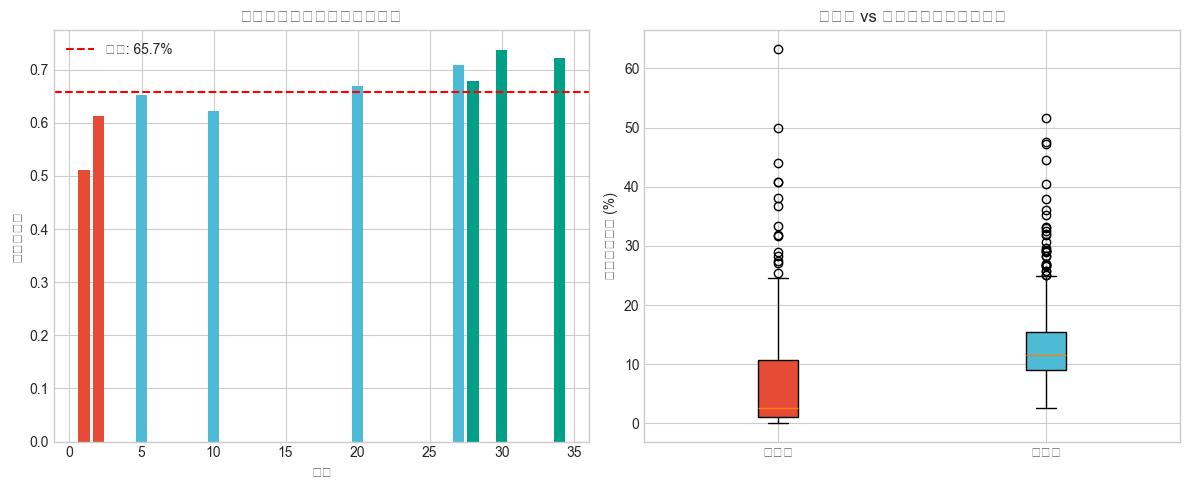

In [46]:
# ==================== 可视化分析 ====================
# 创建两个子图来可视化分析结果

# 创建1行2列的子图布局，总尺寸为12x5英寸
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ==================== 图1: 各赛季确定性柱状图 ====================
ax1 = axes[0]

# 按赛季分组计算平均确定性
season_cert = results_df.groupby('season')['certainty'].mean()

# 根据计分规则设置不同颜色
# S1-2: 红色（排名法早期）
# S3-27: 青色（百分比法）
# S28+: 绿色（排名法后期）
colors = [COLORS[0] if s <= 2 else COLORS[1] if s <= 27 else COLORS[2] for s in season_cert.index]

# 绑制柱状图
ax1.bar(season_cert.index, season_cert.values, color=colors)

# 添加平均线（红色虚线）
ax1.axhline(y=season_cert.mean(), color='red', linestyle='--', label=f'平均: {season_cert.mean():.1%}')

# 设置坐标轴标签和标题
ax1.set_xlabel('赛季')
ax1.set_ylabel('平均确定性')
ax1.set_title('各赛季粉丝投票估计的确定性')
ax1.legend()

# ==================== 图2: 淘汰者vs幸存者粉丝投票箱线图 ====================
ax2 = axes[1]

# 分离淘汰者和幸存者的粉丝投票估计
elim_pct = results_df[results_df['is_elim']]['fan_pct_mean']   # 淘汰者
surv_pct = results_df[~results_df['is_elim']]['fan_pct_mean']  # 幸存者

# 绘制箱线图
# patch_artist=True 允许填充颜色
bp = ax2.boxplot([elim_pct, surv_pct], labels=['淘汰者', '幸存者'], patch_artist=True)

# 设置箱体颜色
bp['boxes'][0].set_facecolor(COLORS[0])  # 淘汰者：红色
bp['boxes'][1].set_facecolor(COLORS[1])  # 幸存者：青色

# 设置坐标轴标签和标题
ax2.set_ylabel('粉丝投票估算 (%)')
ax2.set_title('淘汰者 vs 幸存者的粉丝投票分布')

# 调整子图间距，避免重叠
plt.tight_layout()

# 显示图表
plt.show()

## 10. 结论

In [47]:
# ==================== 方案B总结 ====================
# 打印贝叶斯MCMC模型的总结报告

print("=" * 60)
print("方案B: 贝叶斯MCMC模型（修正版）- 总结")
print("=" * 60)

# ========== 模型改进说明 ==========
# 相比传统方法，本模型做了以下关键改进
print()
print("模型改进:")
print("1. 硬约束似然: 只接受满足淘汰约束的样本")
print("   - 确保所有后验样本都能解释实际淘汰结果")
print("   - 避免了软约束可能导致的不一致问题")
print("2. 分规则建模: 百分比法和排名法分别处理")
print("   - 准确反映了节目在不同时期的计分规则变化")
print("   - 提高了模型在不同赛季的适用性")
print("3. 正确的MH采样: 对称建议分布 + 均匀先验")
print("   - 简化了接受率计算")
print("   - 保证了采样的理论正确性")

# ========== 模型优点 ==========
print()
print("优点:")
print("- 提供完整的后验分布，量化不确定性")
print("  不仅给出点估计，还给出估计的可信范围")
print("- 95%置信区间给出可信范围")
print("  帮助理解估计的精确程度")
print("- 所有样本都满足淘汰约束")
print("  保证了估计结果的逻辑一致性")

# ========== 模型缺点 ==========
print()
print("缺点:")
print("- 计算量较大")
print("  需要大量迭代才能得到足够的后验样本")
print("- 当可行域很小时，接受率低")
print("  约束严格时，大部分建议会被拒绝")
print("- 需要足够的采样数保证收敛")
print("  采样数不足可能导致估计不准确")

方案B: 贝叶斯MCMC模型（修正版）- 总结

模型改进:
1. 硬约束似然: 只接受满足淘汰约束的样本
   - 确保所有后验样本都能解释实际淘汰结果
   - 避免了软约束可能导致的不一致问题
2. 分规则建模: 百分比法和排名法分别处理
   - 准确反映了节目在不同时期的计分规则变化
   - 提高了模型在不同赛季的适用性
3. 正确的MH采样: 对称建议分布 + 均匀先验
   - 简化了接受率计算
   - 保证了采样的理论正确性

优点:
- 提供完整的后验分布，量化不确定性
  不仅给出点估计，还给出估计的可信范围
- 95%置信区间给出可信范围
  帮助理解估计的精确程度
- 所有样本都满足淘汰约束
  保证了估计结果的逻辑一致性

缺点:
- 计算量较大
  需要大量迭代才能得到足够的后验样本
- 当可行域很小时，接受率低
  约束严格时，大部分建议会被拒绝
- 需要足够的采样数保证收敛
  采样数不足可能导致估计不准确
